# Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Evolving the weights of a fixed Neural Controller using CMA-ES.

In [56]:
import importlib
import environment 
import neural_controller
import utils 
importlib.reload(environment)
importlib.reload(neural_controller)
importlib.reload(utils)

import numpy as np
from deap import base, cma, creator, tools, algorithms
import matplotlib.pyplot as plt

In [57]:
initial_setting = {
   'agents': np.array([[0, 5], [0, 10], [0, 15]], dtype=float),
   'blocks': np.array([[9, 16], [10, 12], [11, 6]], dtype=float),
   'colors': np.array([environment.RED, environment.GREEN, environment.RED], dtype=int)
}

env = environment.Environment(objective = [(environment.RED, environment.NORTH_EDGE)],
                   size = environment.SIMULATION_ARENA_SIZE, 
                   n_agents = 3, 
                   n_blocks = 3,
                   n_neighbors = 3,
                   sensor_range = environment.SIMULATION_SENSOR_RANGE,
                   sensor_angle = 360,
                   max_distance_covered_per_step = environment.SIMULATION_MAX_DISTANCE,
                   sensitivity = 0.5,
                   initial_setting = initial_setting)
env.reset()
env.print_env()

. . . . . . 0 . . . . . . 1 . . . . . 2 . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . O . . . . . . . . .
. . . . . . . . O . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .


In [58]:
input_dim = (env.n_types + 2) * env.n_neighbors + env.n_types - 2
output_dim = 2
hidden_units = [16]
layer_sizes = [input_dim] + hidden_units + [output_dim]

nn = neural_controller.NeuralController(layer_sizes, hidden_activation="sigmoid", output_activation="sigmoid")
nn.summary()

NeuralController with layer sizes:  [44, 16, 2]
Total weights: 754, not set


In [59]:
def calculate_fitness(individual, n_steps=100, verbose = False):
        
    fitness = 0
    obs, _ = env.reset()
    
    # Set the weights of the network
    nn.set_weights_from_vector(individual)

    for step in range(n_steps):
        
        nn_inputs = env.process_observation(obs)
        nn_outputs = np.array(nn.predict(nn_inputs))
        actions = np.round(nn_outputs * np.array([env.max_distance_covered_per_step, env.sensor_angle]), 1)
            
        obs, reward, done, _, _ = env.step(actions)

        fitness += reward

        if verbose:
            print("\nStep", step)
            # print("Observation: ", obs)
            # print("NN inputs: ", nn_inputs)
            print("Action: ", actions)
            env.print_env()
            print("Reward: ", reward)
        
        if done:
            fitness += (n_steps - step) / 2
            break
    
    return [float(fitness)]

In [60]:
def selElitistAndTournament(individuals, k_elitist, k_tournament, tournsize):
    return tools.selBest(individuals, k_elitist) + tools.selTournament(individuals, k_tournament, tournsize=tournsize)

In [62]:
population_size = 100
n_elite = int(population_size * 0.05)

# Set up the fitness and individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # Maximization problem
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()

toolbox.register("evaluate", calculate_fitness)

# Strategy parameters for CMA-ES
strategy = cma.Strategy(centroid=[0.0]*nn.total_weights, sigma=1.0, lambda_=population_size)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)
# toolbox.register("select", selElitistAndTournament, k_elitist=n_elite, k_tournament=population_size-n_elite, tournsize=3)

# Statistics to keep track of the evolution
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("best", np.max)
stats.register("avg", np.mean)
stats.register("median", np.median)
stats.register("std", np.std)
stats.register("worst", np.min)

# Using the best strategy to retrieve the best individual
hof = tools.HallOfFame(n_elite)

In [63]:
statistics = algorithms.eaGenerateUpdate(toolbox, ngen=100, stats=stats, halloffame=hof)

gen	nevals	best    	avg     	median	std    	worst   
0  	100   	0.292893	-1.56279	0     	10.3856	-85.2406
1  	100   	0.0560898	-1.44037	0     	8.91552	-67     
2  	100   	0.32199  	-5.43421	0     	22.1362	-151.086
3  	100   	1.50661  	-1.96334	0     	8.72765	-57.5714
4  	100   	0        	-1.99671	0     	9.79045	-70.628 


KeyboardInterrupt: 

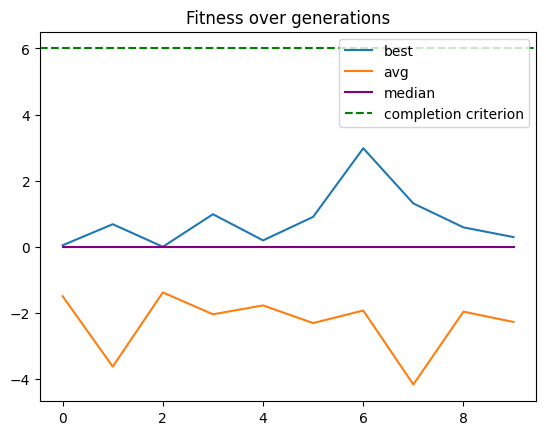

In [55]:
# Plot stats
bests = []
avgs = []
stds = []
medians = []
for stat in statistics[1]:
    bests.append(stat['best'])
    avgs.append(stat['avg'])
    stds.append(stat['std'])
    medians.append(stat['median'])

utils.plot_data(bests, avgs = avgs, medians = medians, 
                completion_fitness=env.n_task * (environment.REWARD_PICK + environment.REWARD_DROP))

In [61]:
calculate_fitness(hof[0], verbose=True)


Step 0
Action:  [[1.9 5.8]
 [1.9 5.8]
 [1.9 5.8]]
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . 0 . . . . . 1 . . . . . 2 . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . O . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . O . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . O . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . O . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .
. . . . . . . . . . . . . . . . . . . . . . . . .

[93.48766574630615]